# IMDB Datasets ETL
__Goal:__ Load relevant IMDB datasets from website and combine them into a single dataset after due preprocessing. The dataset produced by this process is saved in the `10-data` directory.

### Methodological decisions
* Only movies
* Films in @years
* Non adult films
* Exclude Reality-TV, Talk-Show and Game-Show

### Methodological questions
* [ ] Substitute left join for inner join?
* [ ] Exclude Reality-TV, Talk-Show and Game-Show?
* [ ] How to deal with missing values?

### Load packages

In [1]:
import pandas as pd
import numpy as np
import missingno as mn
from collections import Counter
from tqdm import tqdm

### Define paths and constants

In [2]:
years = list(range(2000,2023))
print(min(years), max(years))

2000 2022


In [3]:
basics_url = "https://datasets.imdbws.com/title.basics.tsv.gz"
ratings_url = "https://datasets.imdbws.com/title.ratings.tsv.gz"

In [ ]:
data_dir = "../10-data"

### Define auxiliary functions

In [4]:
def load_imdb_dataset(url, 
                      sep="\t", 
                      encoding="utf-8",
                      index_col="tconst",
                      missing="\\N"):
    
    df = pd.read_csv(url, sep=sep, encoding=encoding, index_col=index_col)
    df[df == missing] = np.nan
    
    print(df.shape, tuple(df.columns))
    return(df)

### ETL

In [5]:
basics = load_imdb_dataset(basics_url)

C:\Users\felbu\AppData\Local\Temp\ipykernel_7872\4031469021.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=sep, encoding=encoding, index_col=index_col)


(9915567, 8) ('titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres')


In [6]:
basics["startYear"] = basics["startYear"].astype("float")
basics["endtYear"] = basics["endYear"].astype("float")

In [7]:
basics.head(6)

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,endtYear
tconst,,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short",NaN
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short",NaN
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4,"Animation,Comedy,Romance",NaN
tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12,"Animation,Short",NaN
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,"Comedy,Short",NaN
tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894.0,NaN,1,Short,NaN


In [8]:
print(basics.shape)

basics = (basics.
          filter(["titleType","primaryTitle","isAdult","startYear","runtimeMinutes","genres"]).
          query("titleType == 'movie'").
          query("isAdult == 0").
          query("startYear.isin(@years)").
          filter(["primaryTitle","startYear","runtimeMinutes","genres"])
         )

print(basics.shape)

(9915567, 9)
(288844, 4)


In [9]:
ratings = load_imdb_dataset(ratings_url)

(1318139, 2) ('averageRating', 'numVotes')


In [10]:
ratings.head()

,averageRating,numVotes
tconst,,
tt0000001,5.7,1979
tt0000002,5.8,265
tt0000003,6.5,1831
tt0000004,5.6,179
tt0000005,6.2,2621


In [11]:
data = pd.merge(basics, ratings, 
                how="left", 
                left_index=True, right_index=True, 
                validate="1:1", 
                indicator=True)

In [12]:
data.head()

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,_merge
tconst,,,,,,,
tt0011801,Tötet nicht mehr,2019.0,NaN,"Action,Crime",NaN,NaN,left_only
tt0013274,Istoriya grazhdanskoy voyny,2021.0,94,Documentary,6.8,56.0,both
tt0015414,La tierra de los toros,2000.0,60,NaN,5.3,16.0,both
tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,86830.0,both
tt0043139,Life of a Beijing Policeman,2013.0,120,"Drama,History",7.2,190.0,both


In [13]:
data._merge.value_counts(normalize=True)

both          0.56087
left_only     0.43913
right_only    0.00000
Name: _merge, dtype: float64

In [14]:
data = data.drop(columns=["_merge"])

### Missing data

<AxesSubplot:>

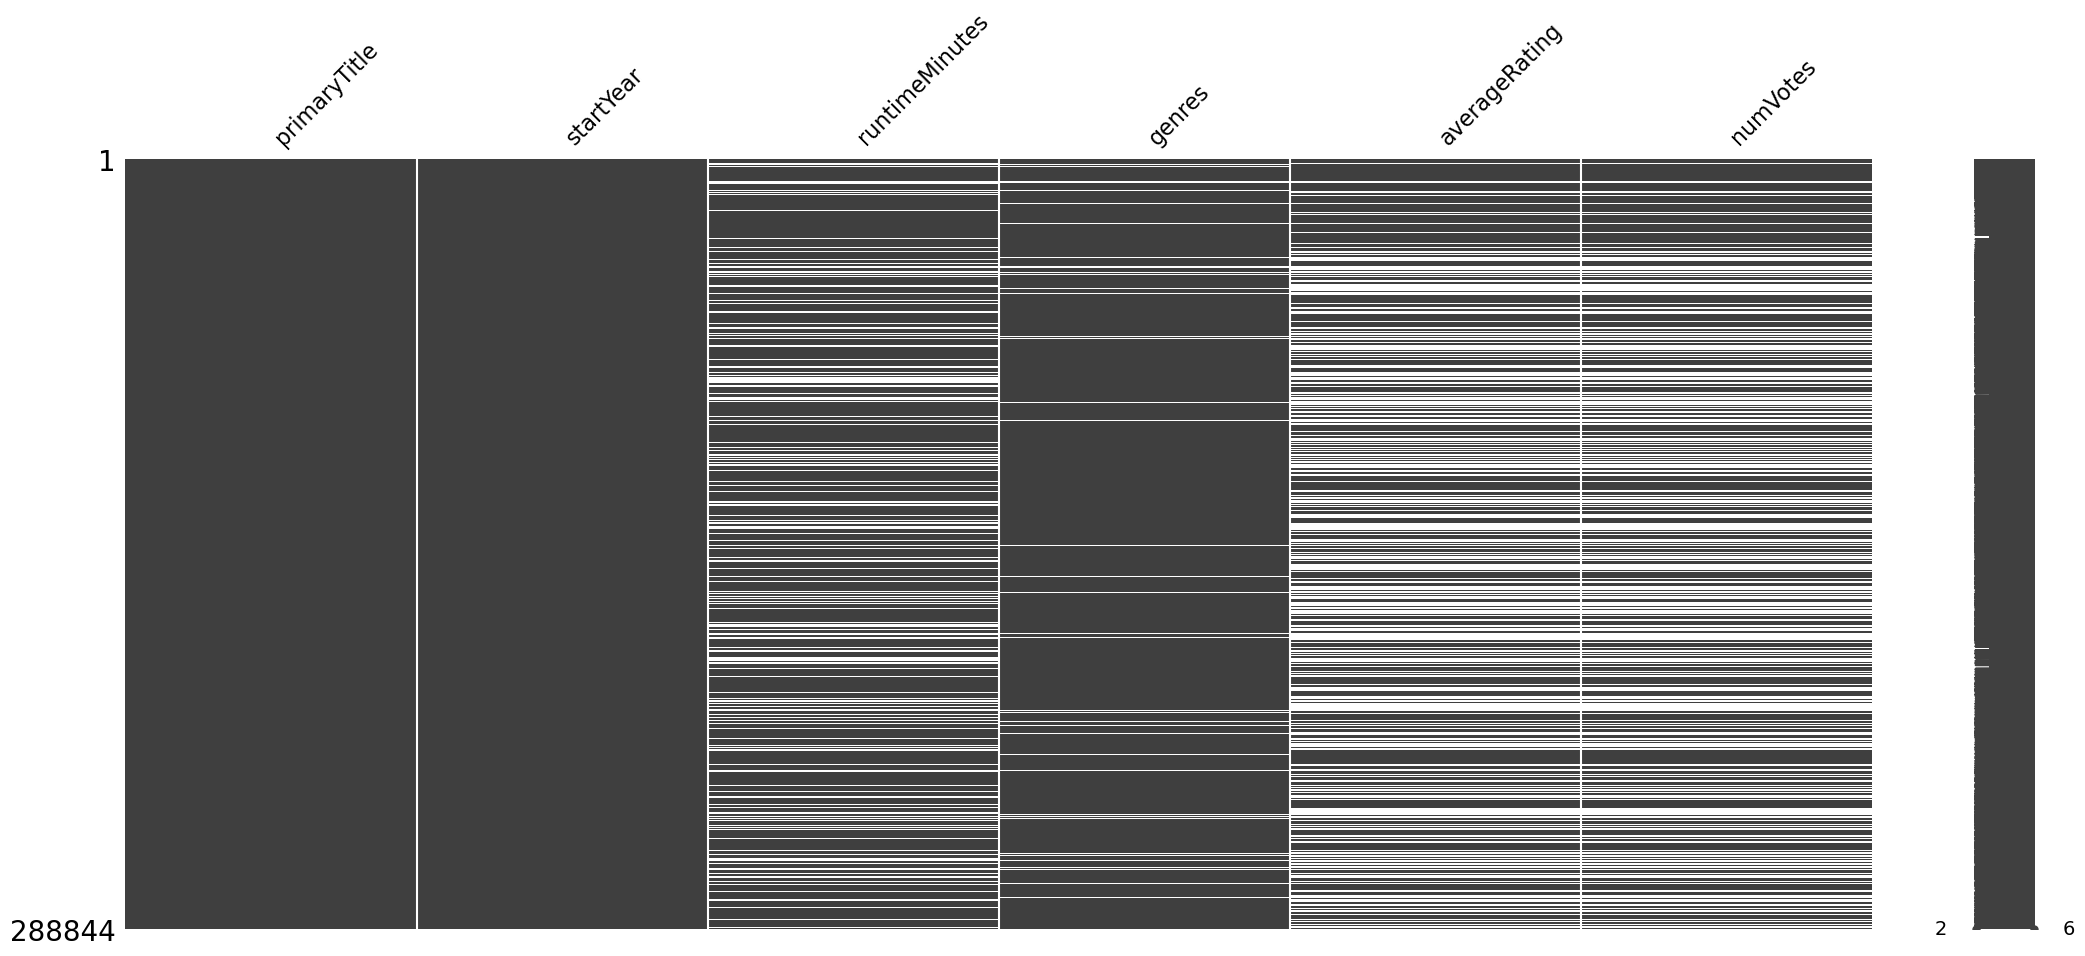

In [15]:
mn.matrix(data)

<AxesSubplot:>

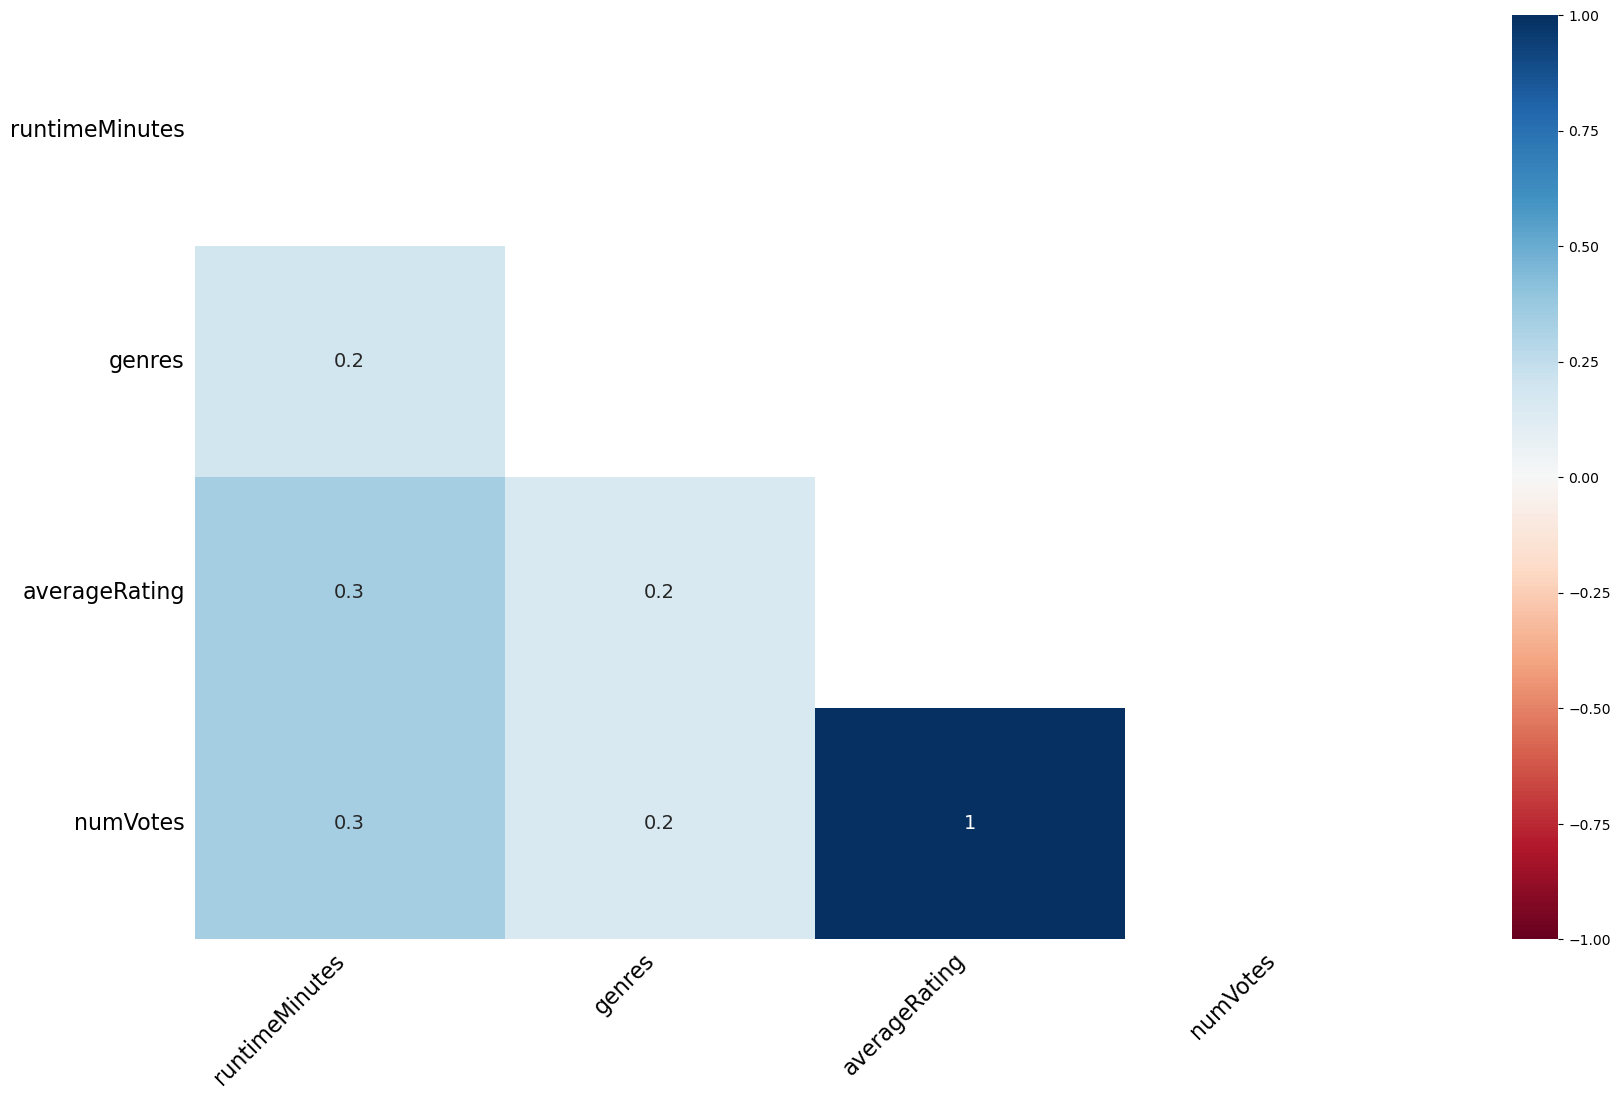

In [16]:
mn.heatmap(data)

### Create variables for genres

In [17]:
all_genres = []
for film_genre in tqdm(data.genres.str.split(",").values):
    try:
        for genre in film_genre:
            all_genres.append(genre)
    except:
        pass


dict(Counter(all_genres))

100%|██████████████████████████████████████████████████████████████████████| 288844/288844 [00:00<00:00, 908718.94it/s]


{'Action': 21100,
 'Crime': 14088,
 'Documentary': 91312,
 'Comedy': 49553,
 'Fantasy': 7012,
 'Romance': 19965,
 'Drama': 100690,
 'History': 8512,
 'Horror': 19753,
 'Sci-Fi': 5914,
 'Biography': 11413,
 'Mystery': 8900,
 'Thriller': 21781,
 'Adventure': 10948,
 'Musical': 2936,
 'Music': 8139,
 'Animation': 5457,
 'Family': 9548,
 'War': 2768,
 'Sport': 4749,
 'Western': 852,
 'News': 1329,
 'Reality-TV': 424,
 'Talk-Show': 143,
 'Game-Show': 14}

In [18]:
all_genres = set(all_genres)
all_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [19]:
data[[list(all_genres)]] = 0

for movie in tqdm(data.iterrows()):
    
    movie_id = movie[0]
    movie_genres = movie[1]["genres"]
    
    for g in all_genres:
        try:
            if g in movie_genres:
                data.loc[movie_id,g] = 1
        except:
            pass
data.head()

288844it [02:23, 2018.61it/s]


,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Romance,Reality-TV,History,News,...,Animation,Musical,Biography,Sport,Thriller,Family,Game-Show,Adventure,Crime,War
tconst,,,,,,,,,,,,,,,,,,,,,
tt0011801,Tötet nicht mehr,2019.0,NaN,"Action,Crime",NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
tt0013274,Istoriya grazhdanskoy voyny,2021.0,94,Documentary,6.8,56.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0015414,La tierra de los toros,2000.0,60,NaN,5.3,16.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",6.4,86830.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0043139,Life of a Beijing Policeman,2013.0,120,"Drama,History",7.2,190.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

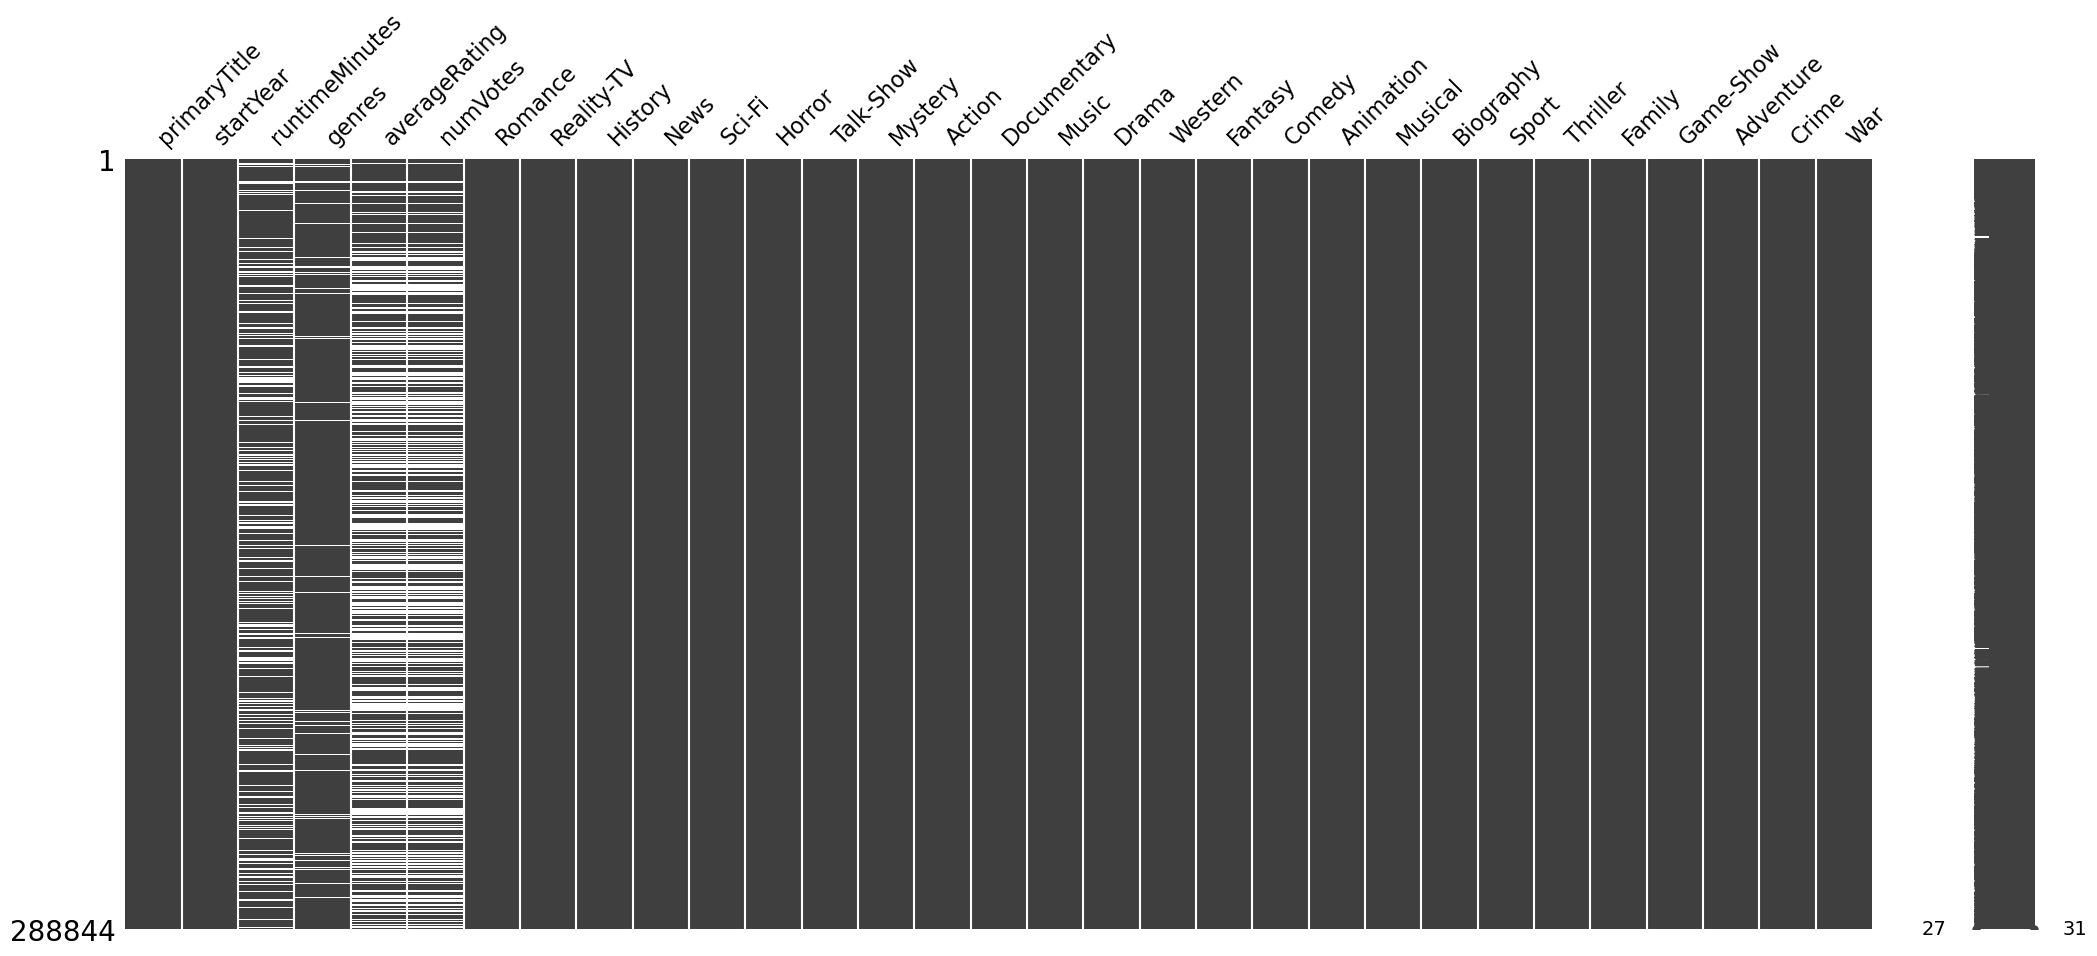

In [21]:
mn.matrix(data)

### Save dataset

In [22]:
data.to_parquet("../10-data/data.parquet")